In [1]:
# unused here:
# !pip install --upgrade huggingface_hub -q
# !pip install --upgrade pip
# !pip install ipywidgets

In [21]:
# # BERTopic only work's properly with torch 2.2.1, higher versions you can have issues
# !pip install torch==2.2.1
# !pip install bertopic
# !pip install bertopic[flair]
# !pip install bertopic[gensim]
# !pip install bertopic[spacy]

#(necessary for "topic_model.visualize_barchart")
# !pip install nbformat 

# # this one is having an issue:
# # !pip install bertopic[use]
 
 
# LDA:
!pip install wordcloud
!pip install gensim
!pip install pyLDAvis
 
 
from IPython.display import clear_output
clear_output()

In [3]:
import nbformat

In case bertopic complains to install in windows due to long paths, enable long paths to install **bertopic** in windows:
1. Open PowerShell as Administrator.
2. In the PowerShell window that opened with administrative privileges, type the following command and press Enter:
```bash
New-ItemProperty -Path "HKLM:\SYSTEM\CurrentControlSet\Control\FileSystem" -Name "LongPathsEnabled" -Value 1 -PropertyType DWORD -Force
```
3. Restart your computer.

In [55]:
import json
import random
import re
import os
import gensim
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sentence_transformers import SentenceTransformer
from gensim.utils import simple_preprocess

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

# import pandas as pd
# import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gutog\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gutog\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# ~1m40s to append the data into a list
# Open the jsonl file

BabyProductsDict = []

with open('data/Baby_Products.jsonl', 'r') as file:
    # Read each line in the file
    for line in file:
        # Parse the JSON data on the line
        BabyProductsDict.append(json.loads(line))
        # Now data is a dictionary representing the JSON object
        # print(data)

In [6]:
print('len():',len(BabyProductsDict),'type:',type(BabyProductsDict))

len(): 6028884 type: <class 'list'>


In [7]:
# sample
# BabyProductsDict[0]['text']

In [8]:
# max_samples = 100000
max_samples = 5000


if len(BabyProductsDict) > max_samples:
    sampled_list = random.sample(BabyProductsDict, max_samples)
else:
    sampled_list = BabyProductsDict

# Print or use the sampled list as needed
print(len(sampled_list))  # Should be max_samples if the original list has more than max_samples items

5000


In [9]:
sampled_list[0]

{'rating': 5.0,
 'title': 'Best bib ever!',
 'text': 'Adorable prints, super soft, love this product!',
 'images': [],
 'asin': 'B010J7ZW88',
 'parent_asin': 'B08716GMGC',
 'user_id': 'AG57HDMDVZRDLTBZ54CKNJBDIKIA',
 'timestamp': 1469103586000,
 'helpful_vote': 0,
 'verified_purchase': True}

In [10]:
# function that transformos a list of dictionaries into a dataframe:

def dict_to_df(dict_list):
    df = pd.DataFrame.from_dict(dict_list)
    return df

BabyProducts_Df = dict_to_df(sampled_list)
BabyProducts_Df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Best bib ever!,"Adorable prints, super soft, love this product!",[],B010J7ZW88,B08716GMGC,AG57HDMDVZRDLTBZ54CKNJBDIKIA,1469103586000,0,True
1,5.0,Great for Newborns,I always get these for new moms. I used them w...,[],B0016A7QYQ,B0016A7QYQ,AH3U6H45GQCBVMX53UZFL2BL67IA,1391616143000,0,True
2,3.0,Adorable but has an odor,The item was adorable. My only complaint is th...,[],B01N1QJ5R7,B01N1QJ5R7,AHHGWDRA6IDKLX2N4RFFIPITUOWA,1628616097351,0,True
3,5.0,Great for 2 in the backseat of most cars though,"My tall 6, 7 and 9-year-olds use these as a sp...",[{'small_image_url': 'https://images-na.ssl-im...,B00ISS2S88,B00ISS2S88,AE7JOVNS4C7U322U2UIIZLDBKBOA,1437159678000,11,True
4,4.0,GREAT for price!,I loved it when my daughter was a bitty thing!...,[],B0002XO5LK,B0002XO5LK,AFEGCFQJZUDKKHSVNC5RT3PUPXKA,1140796432000,4,False


In [11]:
# uma funcao basica de limpeza

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

special_chars = "¨'!#$%&()*+,-./:;<=>?@[\]^_`{|}~"
def preprocess(x):
    new_x = x
    # new_x = x.replace('"',' ')
    new_x = new_x.replace('\n',' ')
    new_x = new_x.replace('\t',' ')
    new_x = new_x.replace('\r',' ')
    # new_x = ' '.join([word for word in nltk.word_tokenize(new_x.lower(), language='portuguese') if word not in stop_words]) #removendo stop words
    # new_x = re.sub(r'[^\w\s]', ' ', new_x) #removendo pontuação do texto
    new_x = re.sub("http\S+", ' ',new_x) # remove links
    new_x = re.sub("@\w+", ' ',new_x) # remove contas com @
    # new_x = re.sub('#\S+', ' ',new_x) # hashtags
    # new_x = re.sub('[0-9]+', ' ',new_x) # remove numeros e palavras com numeros
    for c in special_chars:
        new_x = new_x.replace(c,' ') # caracteres especiais
    new_x = re.sub("\s+", ' ',new_x) # espaços
    new_x = new_x.strip()
    return new_x.lower()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gutog\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#pre process the text:

# BabyProducts_Df['text'] = BabyProducts_Df['text'].apply(lambda x: preprocess(x))
BabyProducts_Df['text'] = BabyProducts_Df['text'].apply(preprocess)

BabyProducts_Df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Best bib ever!,adorable prints super soft love this product,[],B010J7ZW88,B08716GMGC,AG57HDMDVZRDLTBZ54CKNJBDIKIA,1469103586000,0,True
1,5.0,Great for Newborns,i always get these for new moms i used them wi...,[],B0016A7QYQ,B0016A7QYQ,AH3U6H45GQCBVMX53UZFL2BL67IA,1391616143000,0,True
2,3.0,Adorable but has an odor,the item was adorable my only complaint is tha...,[],B01N1QJ5R7,B01N1QJ5R7,AHHGWDRA6IDKLX2N4RFFIPITUOWA,1628616097351,0,True
3,5.0,Great for 2 in the backseat of most cars though,my tall 6 7 and 9 year olds use these as a spa...,[{'small_image_url': 'https://images-na.ssl-im...,B00ISS2S88,B00ISS2S88,AE7JOVNS4C7U322U2UIIZLDBKBOA,1437159678000,11,True
4,4.0,GREAT for price!,i loved it when my daughter was a bitty thing ...,[],B0002XO5LK,B0002XO5LK,AFEGCFQJZUDKKHSVNC5RT3PUPXKA,1140796432000,4,False


### Aplicando BERTopic:

In [13]:
# embeddings and docs format
%time # this is for local VS Code jupyter notebook

docs = list(BabyProducts_Df['text'])
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# sentence_model = SentenceTransformer("all-mpnet-base-v2", device="cuda")
embeddings = sentence_model.encode(docs, show_progress_bar=True)
topic_model = BERTopic(embedding_model=sentence_model)

CPU times: total: 0 ns
Wall time: 0 ns


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [14]:
%time
topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)

CPU times: total: 0 ns
Wall time: 0 ns


In [15]:
print('quantidade de tópicos: ', len(set(topics)))
resultados = topic_model.get_topic_info()
resultados.head(15)

quantidade de tópicos:  94


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1218,-1_it_and_the_for,"[it, and, the, for, to, this, my, is, with, baby]",[love this cover i was skeptical at first wond...
1,0,160,0_diapers_diaper_these_they,"[diapers, diaper, these, they, pampers, are, h...",[i ve used these diapers from 0 to 2 with my f...
2,1,148,1_cup_cups_straw_sippy,"[cup, cups, straw, sippy, drink, leak, these, ...",[we have 6 cups 2 for each of our three little...
3,2,142,2_rash_skin_soap_smell,"[rash, skin, soap, smell, smells, diaper, loti...",[have bought and used this exact brand from wa...
4,3,135,3_seat_car_seats_the,"[seat, car, seats, the, straps, in, is, instal...",[our lo s infant seat with the handle bar down...
5,4,126,4_gate_gates_open_latch,"[gate, gates, open, latch, the, close, door, t...",[bought the gate for the top of the stairs con...
6,5,119,5_basket_storage_toys_baskets,"[basket, storage, toys, baskets, stuffed, hold...",[excellent storage basket material is durable ...
7,6,95,6_wall_stick_off_outlet,"[wall, stick, off, outlet, decals, them, decal...",[we actually really liked them on the wall of ...
8,7,94,7_monitor_camera_br_the,"[monitor, camera, br, the, video, room, we, ni...",[this baby monitor is a great purchase i initi...
9,8,85,8_soft_wash_thin_they,"[soft, wash, thin, they, these, softness, them...","[they are soft and a great size, they are soft..."


In [16]:
topic_model.visualize_barchart(top_n_topics=10, n_words=8)

In [18]:
# com remoção de stop words:

def preprocess_stopwords(x):
    new_x = x
    # new_x = x.replace('"',' ')
    new_x = new_x.replace('\n',' ')
    new_x = new_x.replace('\t',' ')
    new_x = new_x.replace('\r',' ')
    new_x = ' '.join([word for word in nltk.word_tokenize(new_x.lower(), language='portuguese') if word not in stop_words]) #removendo stop words
    # new_x = re.sub(r'[^\w\s]', ' ', new_x) #removendo pontuação do texto
    new_x = re.sub("http\S+", ' ',new_x) # remove links
    new_x = re.sub("@\w+", ' ',new_x) # remove contas com @
    # new_x = re.sub('#\S+', ' ',new_x) # hashtags
    # new_x = re.sub('[0-9]+', ' ',new_x) # remove numeros e palavras com numeros
    for c in special_chars:
        new_x = new_x.replace(c,' ') # caracteres especiais
    new_x = re.sub("\s+", ' ',new_x) # espaços
    new_x = new_x.strip()
    return new_x.lower()

BabyProducts_Df['text'] = BabyProducts_Df['text'].apply(preprocess_stopwords)
docs = list(BabyProducts_Df['text'])
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# sentence_model = SentenceTransformer("all-mpnet-base-v2", device="cuda")
embeddings = sentence_model.encode(docs, show_progress_bar=True)
topic_model = BERTopic(embedding_model=sentence_model)
topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)
topic_model.visualize_barchart(top_n_topics=10, n_words=8)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [19]:
print('quantidade de tópicos: ', len(set(topics)))
resultados = topic_model.get_topic_info()
resultados.head(15)

# resultado: mudou bastante os tópicos com a remoção de stop words
# (como avaliar isso)?

quantidade de tópicos:  91


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1294,-1_great_baby_one_product,"[great, baby, one, product, little, use, easy,...",[baby loves easy hold cute perfect size 9 mont...
1,0,238,0_crib_mattress_bed_sheets,"[crib, mattress, bed, sheets, sheet, play, pac...",[crib sheets best crib sheets think ever house...
2,1,187,1_food_spoon_plate_dishwasher,"[food, spoon, plate, dishwasher, plates, spoon...",[quality design utensils perfect love colors w...
3,2,177,2_diapers_diaper_pampers_brand,"[diapers, diaper, pampers, brand, huggies, clo...",[amazing price using exclusively cloth diapers...
4,3,143,3_gate_dog_gates_dogs,"[gate, dog, gates, dogs, open, latch, close, d...",[gate fits perfectly works well keeping pets c...
5,4,135,4_cup_cups_sippy_straw,"[cup, cups, sippy, straw, drink, leak, spout, ...",[buy purchased target sale 7 dollars change 8 ...
6,5,115,5_seat_car_seats_booster,"[seat, car, seats, booster, britax, install, s...","[great seat, love great quality fits great sea..."
7,6,115,6_wall_stick_walls_stickers,"[wall, stick, walls, stickers, decals, adhesiv...",[actually really liked wall nursery tried remo...
8,7,96,7_monitor_camera_br_video,"[monitor, camera, br, video, night, room, batt...","[good baby monitor, update monitor 2 years one..."
9,8,82,8_potty_toilet_training_seat,"[potty, toilet, training, seat, stool, bathroo...",[potty seat potty training game changer home s...


### Aplicando LDA: 

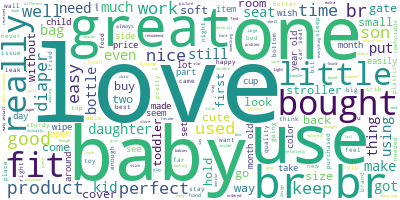

In [27]:
# Import the wordcloud library
from wordcloud import WordCloud

# # Join the different processed titles together.
long_string = ','.join(list(BabyProducts_Df['text'].values))

# # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# # Generate a word cloud

wordcloud.generate(long_string)
# # Visualize the word cloud

wordcloud.to_image()

In [46]:
# # Outro método para remoção de stop words:

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = BabyProducts_Df['text'].values.tolist()
data_words_babies = list(sent_to_words(data))
# remove stop words
data_words_babies = remove_stopwords(data_words_babies)
print(data_words_babies[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gutog\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['adorable', 'prints', 'super', 'soft', 'love', 'product']


In [47]:
import gensim.corpora as corpora

# # Create Corpus
texts = data_words_babies

# # Create Dictionary
id2word = corpora.Dictionary(texts)

# # Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# # View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [51]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

CPU times: total: 0 ns
Wall time: 0 ns
[(0,
  '0.013*"great" + 0.009*"easy" + 0.007*"good" + 0.006*"seat" + 0.006*"love" + '
  '0.006*"price" + 0.005*"perfect" + 0.005*"got" + 0.005*"car" + 0.005*"like"'),
 (1,
  '0.022*"br" + 0.017*"easy" + 0.010*"love" + 0.010*"well" + 0.009*"one" + '
  '0.008*"great" + 0.007*"baby" + 0.007*"little" + 0.007*"old" + 0.006*"like"'),
 (2,
  '0.014*"br" + 0.013*"great" + 0.010*"one" + 0.010*"little" + 0.008*"like" + '
  '0.008*"baby" + 0.008*"easy" + 0.008*"son" + 0.007*"love" + 0.007*"would"'),
 (3,
  '0.017*"baby" + 0.012*"love" + 0.009*"one" + 0.008*"well" + 0.008*"great" + '
  '0.008*"would" + 0.007*"get" + 0.007*"perfect" + 0.006*"size" + '
  '0.006*"diaper"'),
 (4,
  '0.012*"br" + 0.012*"great" + 0.012*"product" + 0.010*"like" + 0.009*"one" + '
  '0.009*"baby" + 0.008*"love" + 0.008*"nice" + 0.007*"would" + 0.007*"also"'),
 (5,
  '0.018*"br" + 0.015*"baby" + 0.013*"great" + 0.011*"easy" + 0.011*"love" + '
  '0.008*"one" + 0.006*"little" + 0.006*"wo

In [62]:
# Analisando os resultados:

import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('lda_results'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, 'lda_results'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.008200  0.005882       1        1  20.707813
5     -0.020898  0.012858       2        1  12.271996
8     -0.012751 -0.005976       3        1  11.870955
3     -0.019409  0.004087       4        1  11.007595
7     -0.003250  0.012244       5        1   9.495353
1     -0.014634  0.035687       6        1   8.426141
4      0.011326 -0.054000       7        1   7.201162
9     -0.000247  0.014326       8        1   7.028692
6     -0.009161 -0.039777       9        1   7.021669
0      0.077224  0.014669      10        1   4.968625, topic_info=        Term         Freq        Total Category  logprob  loglift
28        br  1244.000000  1244.000000  Default  30.0000  30.0000
84      good   495.000000   495.000000  Default  29.0000  29.0000
34      easy   771.000000   771.000000  Default  28.0000  28.0000
3    product   500.000000   500.000000  Default  27.0000  27.0000
164     nice   306.000000   306.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
300   little    20.373601   562.420668  Topic10  -5.4793  -0.3160
159     baby    21.506828  1026.175116  Topic10  -5.4252  -0.8632
178      one    20.484387   904.873031  Topic10  -5.4739  -0.7861
61      well    17.860855   562.746236  Topic10  -5.6109  -0.4482
28        br    19.494440  1244.514923  Topic10  -5.5234  -1.1543

[853 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
8592      8  0.557109     abit
337       1  0.192379     able
337       2  0.090178     able
337       3  0.132260     able
337       4  0.198391     able
...     ...       ...      ...
4684      8  0.125081     zero
4684      9  0.375244     zero
4444      8  0.557110  ziptied
4795      7  0.293132  zoomkit
4795     10  0.586263  zoomkit

[2349 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 9, 4, 8, 2, 5, 10, 7, 1])

**proximos passos:**
- avaliar com todos mais conjuntos de dados que coletei (manter mais ou menos o mesmo numero de reviews)
- fazer a geração de topicos com BERT e com LDA
- encontrar pontos em comum como avaliação de tópicos, ou resultados do proprio dataset no hugging face para comparar 